# Compare Samples

Read in and mask two samples then compare colocalization analysis on each 

### Environment setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.io
import os # For getting file names
import pandas as pd
import czifile # For reading .czi files

%matplotlib inline

# Make sure changes to scripts reload automatically
%load_ext autoreload
%autoreload 2

Also, import some custom scripts

In [2]:
import sys
sys.path.insert(0, '/mnt/c/Users/LJUDY/OneDrive/MyStuff/Programs and Applications/LBNLPracticum/laura/scripts')

In [3]:
import visualization as viz
import explore_and_mask as eam
import metadata as meta

In [4]:
# Set parameters for plots and tables
plt.rcParams['font.family'] = 'monospace'
plt.rcParams['font.size'] = 14
pd.set_option("display.precision", 2)

## Read stack

In [5]:
PATH_TO_SAMPLES = '../../data/confocal_root'
!ls $PATH_TO_SAMPLES/

control_1_1_O1_10x_20201120.czi       control_3_1_O1_20x_20201120.czi
control_1_1_O2_20x_20201120.czi       control_3_2_O2_20x_20201120.czi
control_1_1_O2_20x_20201120_mask.jpg  dry_1_1_O1.2_10x_20201120.czi
control_1_1_O2_20x_20201120_rgb.jpg   dry_1_2_O2_10x_20201120.czi
control_1_1_O2_40x_20201120.czi       dry_2_1_O2_10x_20201120.czi
control_1_2_O1_40x_20201120-003.czi   dry_2_1_O2_20x_20201120.czi
control_1_2_O2_10x_20201120.czi       dry_2_2_O2_20x_20201120.czi
control_1_3_H_40x_20201120.czi	      dry_3_1_H_40x_20201120.czi
control_1_3__40x_20201120.czi	      dry_3_2_H_40x_20201120.czi
control_1_4_H_40x_20201120.czi	      dry_3_3_O3_40x_20201120.czi
control_1_5_O2_40x_20201120.czi       dry_3_4_O2_40x_20201120.czi
control_1_6_O2.3_40x_20201120.czi     dry_4_1_O2.3_40x_20201120.czi
control_2_1_O2.3_10x_20201120.czi     dry_4_2_H_40x_20201120.czi
control_2_1_O2_40x_20201120.czi       dry_4_3_O1_40x_20201120.czi
control_2_2_O1_10x_20201120.czi       gain.csv
control_2_2_O1_40x_20201

In [6]:
#files = ['control_1_1_O2_20x_20201120.czi','dry_2_1_O2_20x_20201120.czi']
#files = [PATH_TO_SAMPLES + "/" + f for f in files]
files = !ls $PATH_TO_SAMPLES/*.czi
#print(files)

### Define settings for analysis

Select the indices for the comparable samples. This must be a list, but it can contain a single index or multiple indices. You must input the same number of indices for both.

In [7]:
num_pairs = 3
pair_labels = ['20x', '40x', '10x']

iControl = [1, 9, 10]
iDry = [19, 25, 18]

Define the two channels of interest and their corresponding colors

In [8]:
# Define channels to pull out of original data
ich1 = 1 # Red -- lignin
ich2 = 0 # Blue -- cellulose

# Define corresponding color channels and labels
ich1_col = 0
ich2_col = 2

ch1_lab = 'Lignin'
ch2_lab = 'Cellulose'

Set whether or not to use thresholding or saturation removal

In [9]:
thresh  = True
no_sat = True

### Validate settings and read files

Verify that you selected the correct files

In [10]:
file_names = [os.path.basename(f) for f in files]
control_files = []
dry_files = []
control_fnames = []
dry_fnames = []

for i in range(num_pairs):
    control_files.append(files[iControl[i]])
    dry_files.append(files[iDry[i]])
    
    control_fnames.append(file_names[iControl[i]])
    dry_fnames.append(file_names[iDry[i]])
    
compare_files = list(zip(control_fnames, dry_fnames))

df = pd.DataFrame(compare_files, columns=['Control', 'Dry'])
df

,Control,Dry
0,control_1_1_O2_20x_20201120.czi,dry_2_1_O2_20x_20201120.czi
1,control_1_6_O2.3_40x_20201120.czi,dry_4_1_O2.3_40x_20201120.czi
2,control_2_1_O2.3_10x_20201120.czi,dry_2_1_O2_10x_20201120.czi


Read in 3D stack using `czifile`

In [11]:
# Read control and dry files
control_stacks = [czifile.imread(f) for f in control_files]
dry_stacks = [czifile.imread(f) for f in dry_files]

# Change dimensions to match convention
# squeeze gets rid of singleton dimensions
# moveaxis moves the color dimension to the end
for iStack in range(num_pairs):
    control_stacks[iStack] = np.moveaxis(np.squeeze(control_stacks[iStack]), 0, -1)
    dry_stacks[iStack] = np.moveaxis(np.squeeze(dry_stacks[iStack]), 0, -1)

# Verify that the shape is now as-expected
print('Reordered shape: ' + str(control_stacks[0].shape))

Reordered shape: (45, 1024, 1024, 3)


## Extract gain and display bright field

Extract the gain values for each channel from the files' metadata and insert only the Cellulose and Lignin gains into the original DataFrame

In [13]:
control_gains = [meta.extract_gains_fluor(f) for f in control_files]
dry_gains = [meta.extract_gains_fluor(f) for f in dry_files]

df_ctrl_gain = pd.DataFrame(control_gains, columns=['Cellulose', 'Lignin'])
df_dry_gain = pd.DataFrame(dry_gains, columns=['Cellulose', 'Lignin'])

df.insert(1, 'CtrlCelGain', df_ctrl_gain['Cellulose'])
df.insert(2, 'CtrlLigGain', df_ctrl_gain['Lignin'])
df.insert(len(df.columns), 'DryCelGain', df_dry_gain['Cellulose'])
df.insert(len(df.columns), 'DryLigGain', df_dry_gain['Lignin'])
df

,Control,CtrlCelGain,CtrlLigGain,Dry,DryCelGain,DryLigGain
0,control_1_1_O2_20x_20201120.czi,377.92,640.94,dry_2_1_O2_20x_20201120.czi,409.87,622.49
1,control_1_6_O2.3_40x_20201120.czi,518.18,649.62,dry_4_1_O2.3_40x_20201120.czi,518.18,708.06
2,control_2_1_O2.3_10x_20201120.czi,601.00,725.00,dry_2_1_O2_10x_20201120.czi,572.00,716.00


Look at max projections

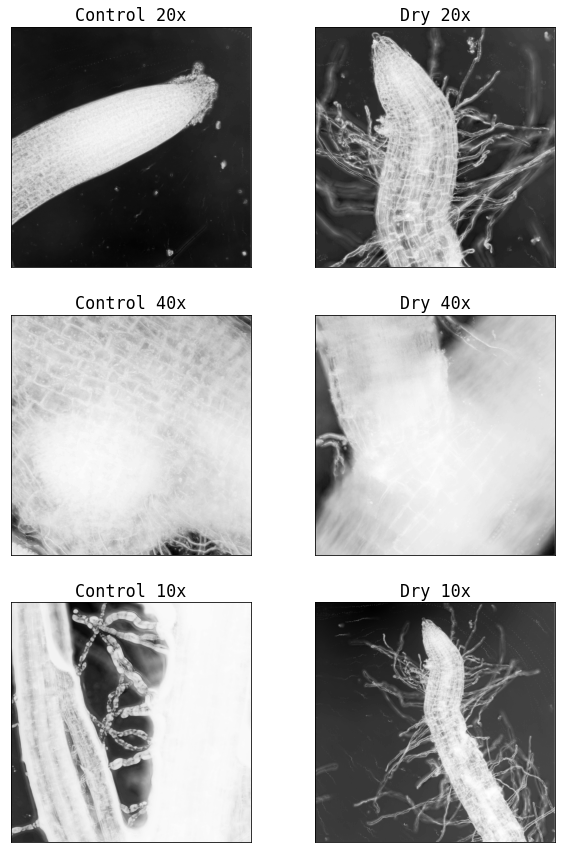

In [14]:
_, ax = plt.subplots(nrows=num_pairs, ncols=2, figsize=(10, 5*num_pairs))

for iPair in range(num_pairs):
    bf = meta.get_bf_ch_index(control_files[i])
    viz.get_and_show_max_proj(ax[iPair,0], 255-control_stacks[iPair][:,:,:,bf], title='Control '+pair_labels[iPair])
    bf = meta.get_bf_ch_index(dry_files[i])
    viz.get_and_show_max_proj(ax[iPair,1], 255-dry_stacks[iPair][:,:,:,2], title='Dry '+pair_labels[iPair])

## Compare masking methods

### Triangle method thresholding on max projection

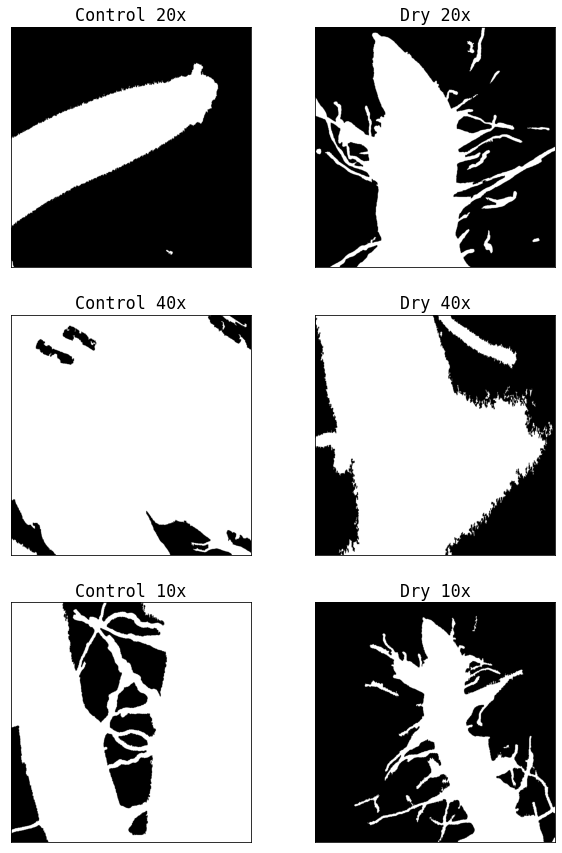

In [81]:
_, ax = plt.subplots(nrows=num_pairs, ncols=2, figsize=(10, 5*num_pairs))

binary_control = []
binary_dry = []

for iPair in range(num_pairs):
    binary_control.append(eam.get_mask_unsupervised_max_proj(control_stacks[iPair], order=(1, 1, 1)))
    binary_dry.append(eam.get_mask_unsupervised_max_proj(dry_stacks[iPair], order=(1, 1, 1)))

    viz.show_plane(ax[iPair,0], binary_control[iPair], title='Control '+pair_labels[iPair])
    viz.show_plane(ax[iPair,1], binary_dry[iPair], title='Dry '+pair_labels[iPair])

### Max projection of triangle threshold by slice

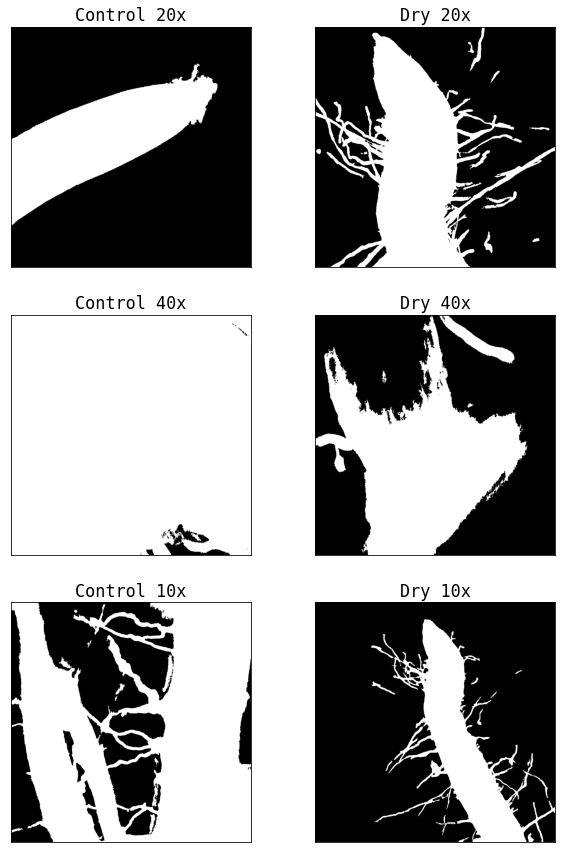

In [84]:
_, ax = plt.subplots(nrows=num_pairs, ncols=2, figsize=(10, 5*num_pairs))

binary_control = []
binary_dry = []

for iPair in range(num_pairs):
    binary, t = eam.get_mask_unsupervised_by_slice(control_stacks[iPair], order=(1, 1, 1))
    binary_control.append(binary)
    #print(f'Control {pair_labels[iPair]}:')
    #print(t)
    
    binary, t = eam.get_mask_unsupervised_by_slice(dry_stacks[iPair], order=(1, 1, 1))
    binary_dry.append(binary)
    #print(f'Dry {pair_labels[iPair]}:')
    #print(t)

    viz.show_plane(ax[iPair,0], np.max(binary_control[iPair], axis=0), title='Control '+pair_labels[iPair])
    viz.show_plane(ax[iPair,1], np.max(binary_dry[iPair], axis=0), title='Dry '+pair_labels[iPair])